In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import pyfolio as pf
warnings.simplefilter('ignore')

# Elastic Asset Allocation (EAA) Strategy

The Elastic Asset Allocation (EAA) strategy is an advanced tactical asset allocation method that generalizes the Flexible Asset Allocation (FAA) model by incorporating cardinal elasticities. Here is a mathematically formal explanation of the EAA strategy, following the details provided in the paper:

## 1. Introduction

The Elastic Asset Allocation (EAA) strategy, proposed by Wouter J. Keller and Adam Butler, builds on the Flexible Asset Allocation (FAA) framework by using a geometrical weighted average of historical returns, volatilities, and correlations, with elasticities as weights. This method aims to create a more efficient portfolio by considering the persistence of returns, volatilities, and correlations over short-term horizons.

## 2. Generalized Momentum Score

The EAA model defines a generalized momentum score $ z_i $ for each asset $ i $ in the universe. The score combines the return $ r_i $, volatility $ v_i $, and correlation $ c_i $ of the asset with the index (equal-weighted universe). The score is given by:

$ z_i = (r_i)^{w_R} \cdot (1 - c_i)^{w_C} \cdot (v_i)^{-w_V} $

where:
- $ r_i $: Return of asset $ i $
- $ v_i $: Volatility of asset $ i $
- $ c_i $: Correlation of asset $ i $ with the equal-weighted index
- $ w_R, w_V, w_C $: Non-negative elasticities for return, volatility, and correlation, respectively

## 3. Portfolio Weights

The optimal portfolio weight $ w_i $ for each asset $ i $ is proportional to its generalized momentum score $ z_i $. The weights are normalized to ensure that they sum up to 1 (long-only portfolio):

$ w_i = \frac{z_i}{\sum_{j=1}^{N} z_j} $

where $ N $ is the total number of assets in the universe.

## 4. Crash Protection (CP)

EAA incorporates a Crash Protection (CP) mechanism that reallocates a portion of the portfolio to a safe asset (e.g., cash or Treasury bills) based on the fraction of assets with non-positive returns. The fraction of the portfolio allocated to the safe asset $ w_{CP} $ is given by:

$ w_{CP} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(r_i \leq 0) $

where $ \mathbf{1} $ is the indicator function that equals 1 if the condition is true and 0 otherwise. The remaining fraction $ 1 - w_{CP} $ is allocated to the top $ N_{Top} $ assets based on their generalized momentum scores.

## 5. Monthly Rebalancing

EAA rebalances the portfolio at the end of each month based on the updated generalized momentum scores. The steps for rebalancing are:

1. **Calculate Returns, Volatilities, and Correlations**:
   - $ r_i $: Average total excess return over the last 1, 3, 6, and 12 months.
   - $ v_i $: Standard deviation of the last 12 monthly total returns.
   - $ c_i $: Correlation between the last 12 monthly total returns of asset $ i $ and the equal-weighted index.

2. **Compute Generalized Momentum Scores**:
   - Calculate $ z_i $ for each asset using the formula above.

3. **Determine Portfolio Weights**:
   - Normalize the scores to obtain $ w_i $.

4. **Apply Crash Protection**:
   - Adjust the portfolio weights to allocate $ w_{CP} $ to the safe asset.

5. **Allocate Remaining Portfolio**:
   - Distribute $ 1 - w_{CP} $ among the top $ N_{Top} $ assets.



[*********************100%%**********************]  14 of 14 completed


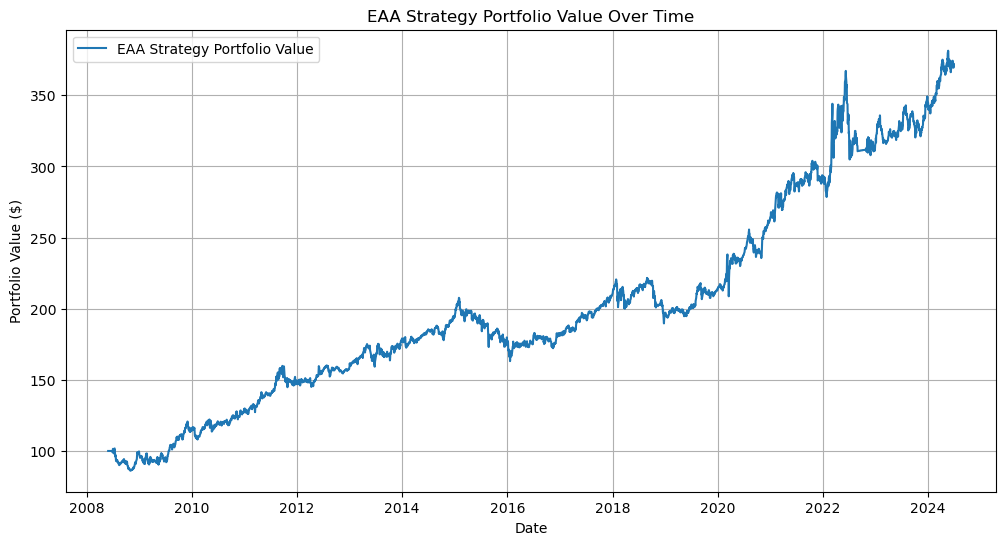

In [23]:
# Define assets
assets = ['SPY', 'QQQ', 'IWM', 'VGK', 'EWJ', 'EEM', 'VNQ', 'DBC', 'GLD', 'HYG', 'LQD', 'TLT', "BIL", "IEF"]

# Download data
data = yf.download(assets, start="2007-06-01")['Adj Close']
monthly_prices = data.resample('BM').last()
returns = monthly_prices.pct_change()

# Calculate return, volatility, and correlation
ri_1m = returns
ri_3m = returns.rolling(window=3).mean()
ri_6m = returns.rolling(window=6).mean()
ri_12m = returns.rolling(window=12).mean()
ri = (ri_1m + ri_3m + ri_6m + ri_12m) / 4

vi = returns.rolling(window=12).std()
equal_weighted_index = returns.mean(axis=1)
ci = pd.DataFrame(index=ri.index, columns=risk_assets)
for asset in risk_assets:
    ci[asset] = returns[asset].rolling(window=12).corr(equal_weighted_index)

# Elasticities
wR, wV, wC = 1, 0, 1  # Adjust these values based on optimization

# Generalized momentum score
zi = (ri ** wR) * ((1 - ci) ** wC) / (vi ** wV)
zi = zi.clip(lower=0)  # Set negative scores to zero

# Normalize weights
wi = zi.div(zi.sum(axis=1), axis=0)

# Combine weights
allocations = pd.concat([wi], axis=1)

# Forward fill allocations to daily frequency
daily_allocation_df = allocations.reindex(data.index, method='ffill')

# Calculate daily returns of the strategy
strategy_daily_returns = pd.Series(0, index=data.index)
for date, allocation in daily_allocation_df.iterrows():
    daily_returns = sum(data[asset].pct_change().loc[date] * weight for asset, weight in allocation.items() if weight > 0)
    strategy_daily_returns.loc[date] = daily_returns

# Define initial investment
initial_investment = 100

# Calculate the cumulative returns of the strategy
strategy_cumulative_returns = (1 + strategy_daily_returns).cumprod()

# Calculate the portfolio value over time
portfolio_value = strategy_cumulative_returns * initial_investment

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='EAA Strategy Portfolio Value')
plt.title('EAA Strategy Portfolio Value Over Time')
plt.xlabel('Date')

plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


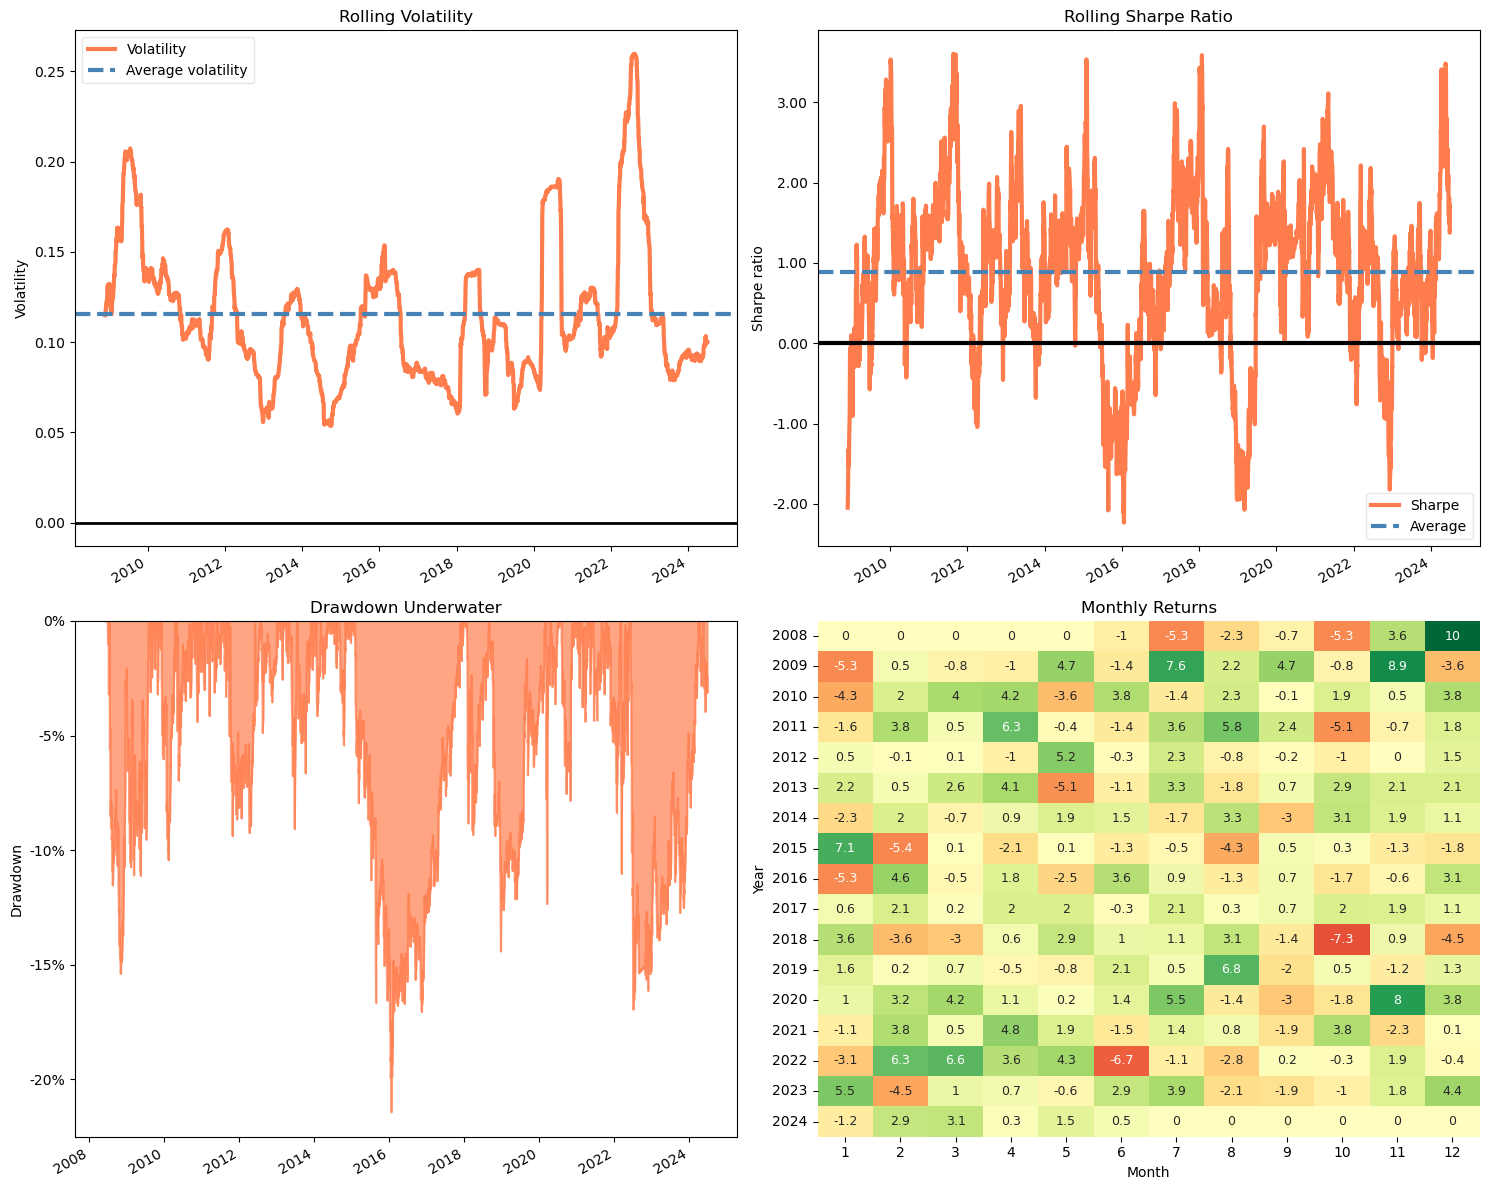

Annual return          0.085282
Cumulative returns     2.720975
Annual volatility      0.121311
Sharpe ratio           0.735494
Calmar ratio           0.397775
Stability              0.935816
Max drawdown          -0.214398
Omega ratio            1.142169
Sortino ratio          1.032139
Skew                  -0.398938
Kurtosis               5.620587
Tail ratio             0.957909
Daily value at risk   -0.014930
dtype: float64


In [24]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()

perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

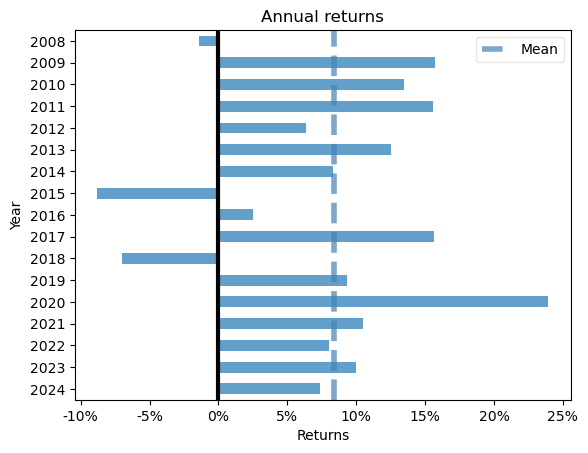

In [25]:
pf.plot_annual_returns(strategy_returns)